In [1]:
import os
import gc
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Setup the device to be used for training and evaluation
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    x = torch.ones(1, device=DEVICE)
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    x = torch.ones(1, device=DEVICE)
    print("Using Apple Metal Performance Shaders (MPS) device.")
else:
    DEVICE = torch.device("cpu")
    print("No GPU found. Defaulting to CPU.")

Using Apple Metal Performance Shaders (MPS) device.


# Config

In [3]:
from utils import JupyterArgParser
from pathlib import Path

# ========= global settings =========
# Taken from i2sb paper with minor changes

RESULT_DIR = Path("results")

# --------------- basic ---------------
parser = JupyterArgParser()
parser.add_argument("--seed",           type=int,   default=0)
parser.add_argument("--name",           type=str,   default=None,        help="experiment ID")
parser.add_argument("--ckpt",           type=str,   default=None,        help="resumed checkpoint name")
parser.add_argument("--device",         type=str,   default=DEVICE,      help="type of device to use for training")
parser.add_argument("--gpu",            type=int,   default=None,        help="set only if you wish to run on a particular GPU")

# --------------- model ---------------
parser.add_argument("--image-size",     type=int,   default=256)
parser.add_argument("--t0",             type=float, default=1e-4,        help="sigma start time in network parametrization")
parser.add_argument("--T",              type=float, default=1.,          help="sigma end time in network parametrization")
parser.add_argument("--interval",       type=int,   default=1000,        help="number of interval")
parser.add_argument("--beta-max",       type=float, default=0.3,         help="max diffusion for the diffusion model")
parser.add_argument("--beta-schedule",  type=str,   default="i2sb",    help="schedule for beta")
parser.add_argument("--ot-ode",         action="store_true",             help="use OT-ODE model")
parser.add_argument("--clip-denoise",   action="store_true",             help="clamp predicted image to [-1,1] at each")
parser.add_argument("--use-fp16",       action="store_true",             help="use fp16 for training")
parser.add_argument("diffusion-type",   type=str,   default="schrodinger_bridge",      help="type of diffusion model")

# --------------- optimizer and loss ---------------
parser.add_argument("--batch-size",     type=int,   default=256)
parser.add_argument("--microbatch",     type=int,   default=4,           help="accumulate gradient over microbatch until full batch-size")
parser.add_argument("--num-itr",        type=int,   default=8001,     help="training iteration")
parser.add_argument("--lr",             type=float, default=5e-5,        help="learning rate")
parser.add_argument("--lr-gamma",       type=float, default=0.99,        help="learning rate decay ratio")
parser.add_argument("--lr-step",        type=int,   default=1000,        help="learning rate decay step size")
parser.add_argument("--l2-norm",        type=float, default=0.0)
parser.add_argument("--ema",            type=float, default=0.99)

# --------------- path and logging ---------------
parser.add_argument("--dataset-dir",    type=Path,  default="/dataset",  help="path to LMDB dataset")
parser.add_argument("--log-dir",        type=Path,  default=".log",      help="path to log std outputs and writer data")
parser.add_argument("--log-writer",     type=str,   default=None,        help="log writer: can be tensorbard, wandb, or None")
parser.add_argument("--wandb-api-key",  type=str,   default=None,        help="unique API key of your W&B account; see https://wandb.ai/authorize")
parser.add_argument("--wandb-user",     type=str,   default=None,        help="user name of your W&B account")
parser.add_argument("--ckpt-path",      type=Path,  default=None,        help="path to save checkpoints")
parser.add_argument("--load",           type=Path,  default=None,        help="path to load checkpoints")
parser.add_argument("--unet_path",      type=str,   default=None,        help="path of UNet model to load for training")

# --------------- distributed ---------------
parser.add_argument("--local-rank",     type=int,   default=0)
parser.add_argument("--global-rank",    type=int,   default=0)
parser.add_argument("--global-size",    type=int,   default=1)

opt = parser.get_options()
# ========= path handle =========
opt.name = "test"
os.makedirs(opt.log_dir, exist_ok=True)
opt.ckpt_path = RESULT_DIR / opt.name if opt.name else RESULT_DIR / "temp"
os.makedirs(opt.ckpt_path, exist_ok=True)

if opt.ckpt:
    ckpt_file = RESULT_DIR / opt.ckpt / "latest.pt"
    assert ckpt_file.exists()
    opt.load = ckpt_file
else:
    opt.load = None

# ========= auto assert =========
assert opt.batch_size % opt.microbatch == 0, f"{opt.batch_size=} is not dividable by {opt.microbatch}!"



# Prepare Data

In [ ]:
from data import SuperResolutionDataset

# build dataset    
hr_latent_path = 'data/one_meter_naip/224naip_latent_dataset_drone.npy'
lr_latent_path = 'data/one_meter_naip/224naip_latent_dataset_satellite.npy'
hr_latent = np.load(hr_latent_path, mmap_mode='r') # shape (B, C, H, W)
lr_latent = np.load(lr_latent_path, mmap_mode='r')
assert len(hr_latent) == len(lr_latent), f"hr_latent b={hr_latent.shape[0]} and lr_latent b={lr_latent.shape[0]} don't have the same B"

B = len(hr_latent)
split = int(0.9*B) # 90:10 train:test split

# shuffle loaded data before split
rng = np.random.default_rng(seed=42)
perm = rng.permutation(B)
train_idx = perm[:split]
val_idx = perm[split:]

train_hr, val_hr = hr_latent[train_idx], hr_latent[val_idx]
train_lr, val_lr = lr_latent[train_idx], lr_latent[val_idx]

train = SuperResolutionDataset(hr_images=train_hr, lr_images=train_lr, transform=None)
val = SuperResolutionDataset(hr_images=val_hr, lr_images=val_lr, transform=None)
print(f"Dataset lengths: train={len(train)} val={len(val)}")

del train_hr, val_hr, train_lr, val_lr, hr_latent, lr_latent
gc.collect()

Dataset lengths: train=40986 val=4554


113

In [ ]:
from i2sb.runner import Runner

# build runner
run = Runner(opt)
# train
train_loss, eval_loss = run.train(opt, train, val)


/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Built schrodinger_bridge Diffusion Model with 1000 steps and i2sb beta schedule!


train_inner_loop: 100%|██████████| 64/64 [04:28<00:00,  4.20s/it]  


train_it 1/8001 | lr:5.00e-05 | loss:+135.6477
Saved latest(iteration=0) checkpoint to opt.ckpt_path=PosixPath('results/test')!


eval_inner_loop: 100%|██████████| 64/64 [00:10<00:00,  6.31it/s]


EVALUATE: eval_it 1/8001 | loss:+86.4169


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 99.42it/s] 


train_it 2/8001 | lr:5.00e-05 | loss:+99.9964


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 102.04it/s]


train_it 3/8001 | lr:5.00e-05 | loss:+69.0586


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 104.23it/s]


train_it 4/8001 | lr:5.00e-05 | loss:+50.9576


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 113.82it/s]


train_it 5/8001 | lr:5.00e-05 | loss:+35.0090


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 101.25it/s]


train_it 6/8001 | lr:5.00e-05 | loss:+25.6094


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 105.72it/s]


train_it 7/8001 | lr:5.00e-05 | loss:+19.4070


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 101.65it/s]


train_it 8/8001 | lr:5.00e-05 | loss:+15.6107


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 99.10it/s] 


train_it 9/8001 | lr:5.00e-05 | loss:+12.8510


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 85.82it/s]


train_it 10/8001 | lr:5.00e-05 | loss:+11.1587


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 54.17it/s]


train_it 51/8001 | lr:5.00e-05 | loss:+1.7435


eval_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 156.34it/s]


EVALUATE: eval_it 51/8001 | loss:+1.7713


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 79.18it/s]


train_it 101/8001 | lr:5.00e-05 | loss:+1.1177


eval_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 82.50it/s] 


EVALUATE: eval_it 101/8001 | loss:+1.1142


In [ ]:
del run
del train, val
gc.collect()

424

In [ ]:
np.save('train_loss.npy', train_loss)

eval_iters = []
eval_losses = []
for it, loss in eval_loss:
  eval_iters.append(it)
  eval_losses.append(loss)
np.save('eval_iters.npy', eval_iters)
np.save('eval_loss.npy', eval_losses)

del train_loss, eval_loss
gc.collect()

In [ ]:
tl = np.load('train_loss.npy')
ti = np.arange(0, len(tl))
ei = np.load('eval_iters.npy')
el = np.load('eval_loss.npy')

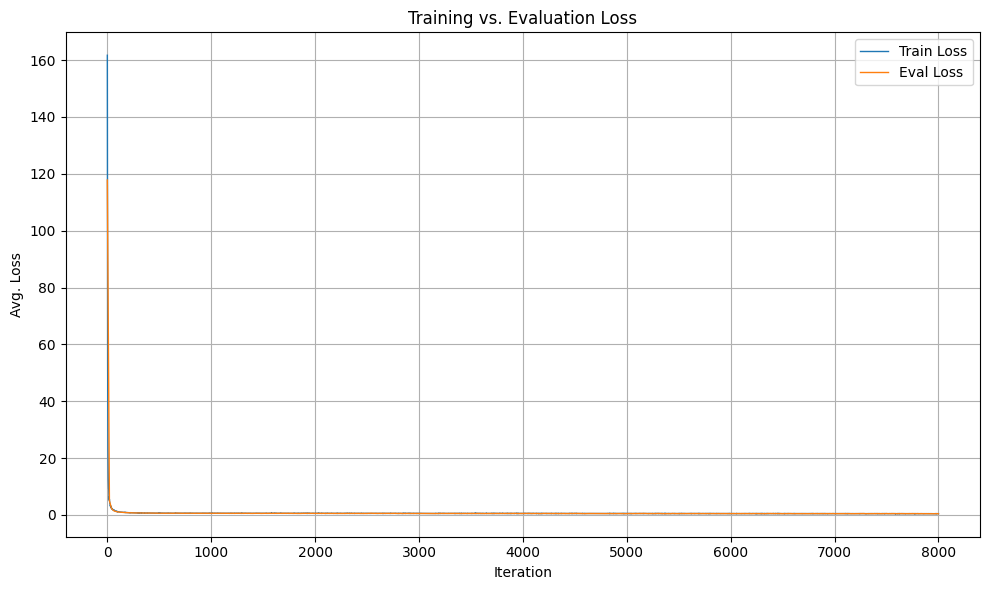

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(ti, tl, label='Train Loss', linewidth=1)
plt.plot(ei, el, label='Eval Loss', linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Avg. Loss')
plt.title('Training vs. Evaluation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# # Image transition plotter
# # source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

# torch.manual_seed(opt.seed)
# def plot_images(imgs, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs[0], list):
#         # Make a 2d grid even if there's just 1 row
#         imgs = [imgs]

#     num_rows = len(imgs)
#     num_cols = len(imgs[0]) + with_orig
#     _, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
#     for row_idx, row in enumerate(imgs):
#         for col_idx, img in enumerate(row):
#             ax = axs[row_idx, col_idx]
#             ax.imshow(np.asarray(img), **imshow_kwargs)
#             ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
#     if row_title is not None:
#         for row_idx in range(num_rows):
#             axs[row_idx, 0].set(ylabel=row_title[row_idx])

#     plt.tight_layout()